In [1]:
#############################################################
#
# NBA Individual Player Performance Prediction
#
#############################################################
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

from mrsc.src.from_tslib.svdWrapper import SVDWrapper as SVD
from mrsc.src.from_tslib.tsSVDModel import SVDModel
from mrsc.src.from_tslib import tsUtils

from statsmodels.tsa.arima_model import ARMA

# for entropy
import zlib
import binascii
import re
import math

import pylab 
import scipy.stats as stats
from scipy.stats import entropy
from scipy.stats import bernoulli
from math import log, e
import timeit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

plt.rcParams.update({'font.size': 14})

In [85]:
"""
import data
"""
print("*** importing data ***")

annual_pred = pd.read_pickle("annual_pred_2016.pkl")
target_players = list(annual_pred.columns)

data = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")

game_metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
year_metrics = ['PTS_G','AST_G','TOV_G','TRB_G','STL_G','BLK_G','3P_G','FG%','FT%']
colname_dict = {'playPTS': 'PTS_G', 'playAST': 'AST_G', 'playTO':'TOV_G',
                'playFG%': 'FG%','playFT%':'FT%','play3PM':'3P_G',
                'playTRB':'TRB_G','playSTL':'STL_G','playBLK':'BLK_G'}

# edit column names to fit with the yearly data
data = data.rename(columns=colname_dict)

date_col = pd.to_datetime(data.gmDate + " " + data.gmTime, format='%Y-%m-%d %H:%M').rename("date")
data = pd.concat([date_col,data], axis=1)

stats_game = data[["date","gmDate","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

df = pd.read_pickle("../data/nba-hosoi/nba_scores_2103-2018.pkl")
df = df[["nbaId","path","game_date","home","away","season"]].drop_duplicates().reset_index(drop=True)

a = pd.concat([df,(df["game_date"] + str(" ") + df["home"]).rename("key")], axis=1)
b = pd.concat([df,(df["game_date"] + str(" ") + df["away"]).rename("key")], axis=1)
appended = pd.concat([a,b], axis=0)

new_data = pd.concat([data, (data["gmDate"] + str(" ") + data["teamAbbr"]).rename("key")], axis=1)
data_fin = new_data.merge(appended, how='left', left_on='key', right_on='key')

stats_game = data_fin[["date","gmDate","gmTime","nbaId","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

player_list_1 = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
player_list_2 = ['Al Horford','Trevor Ariza','Eric Gordon']

*** importing data ***


In [12]:
def compress(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}
    
    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return result

def decompress(compressed):
    """Decompress a list of output ks to a string."""
 
    dict_size = 256
    dictionary = dict((i, chr(i)) for i in range(dict_size))
 
    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    result = StringIO()
    w = chr(compressed.pop(0))
    result.write(w)
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result.write(entry)
 
        # Add w+entry[0] to the dictionary.
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
 
        w = entry
    return result.getvalue()

def entropy(p):
    return -p*log(p, 2) - (1-p)*log(1-p,2)

def list_to_string(a):
    return re.sub('\W+','', str(a) )

def lzw_test(delta):
    delta_string = list_to_string(delta)
    delta_compressed = compress(delta_string)
    delta_decompressed = decompress(delta_compressed)
    ratio = len(delta_compressed)/len(delta_string)
    error = np.sum(np.array([int(i) for i in delta_string]) != np.array([int(i) for i in delta_decompressed]))
    
    print("- using lzw")
    print("original size   : ", len(delta))
    print("compressed size : ", len(delta_compressed))
    print("ratio           : ", ratio)
    print("error           : ", error/len(delta_string))

def random_generator(size, p=0.5, space=50):
    numrand = np.random.binomial(1,p, size=size*space)
    spaced = numrand[0::space]
    a = list(spaced.astype(int))
    random_str = list_to_string(a)
    return random_str

def get_delta(x):
    delta = np.zeros(len(x)-1)
    delta[(x - x.shift(+1))[1:]>0] = 1
    # 1 = increase
    # 0 = not increase (decrease or stays the same)
    delta = delta.astype(int)
    return list(delta)

def regression_model(size, number_of_p=30, verbose=False):
    ratio_list =[]
    true_entropy = []
    for p in np.linspace(1e-5,0.5,number_of_p):
        true_entropy.append(entropy(p))
        uncompressed = random_generator(size, p)
        compressed = compress(uncompressed)
        compression_ratio = len(compressed)/len(uncompressed)
        ratio_list.append(compression_ratio)
        
        if verbose:
            print("p : ", p)
            print("theoretical entropy: ", entropy(p))
            print("compression ratio: ", compression_ratio)
            print()

    # linear regression
    reg = LinearRegression().fit(np.array(true_entropy[:]).reshape(-1, 1), np.array(ratio_list[:]))
    print("y = ax + b model")
    print("a = ", reg.coef_)
    print("b = ", reg.intercept_)

    plt.plot(true_entropy, ratio_list, marker='.', label = "LZW compressor")
    plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression")

    plt.title("Compression Ratio of size {} Bernoulli(p), 0<p<0.5".format(size))
    plt.xlabel("theoretical entropy")
    plt.ylabel("compression ratio")
    plt.legend()
    plt.show()

    return ratio_list, true_entropy

# Lower Bound

In [87]:
def get_entropy(size, compression_ratio):
    # mapping compression ratio to entropy
    ratio_list, true_entropy = regression_model(size, number_of_p=30, verbose=False)
    reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))
    return reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))

def f(p):
    return -p*log(p,2) - (1-p)*log(1-p,2)

def df(p):
    return -log(p/(1-p),2) 

def inverse_binary_entropy(H, a=0.001):
    # from entropy value, get p s.t. 0 < p < 0.5
    # a = accuracy
    p_hat = 0.25
    err = np.abs(f(p_hat) - H)
    while(err > a):
        err = np.abs(f(p_hat) - H)
        p_hat = p_hat - 0.01* (f(p_hat) - H) * df(p_hat)
        if (p_hat<0):
            p_hat = 0
        if (p_hat>0.5):
            p_hat = 0.5
#         print(p_hat)
    
    return p_hat

Stephen Curry
p =  0.5022522522522522
length =  444
y = ax + b model
a =  [0.16651179]
b =  0.07271018451169758


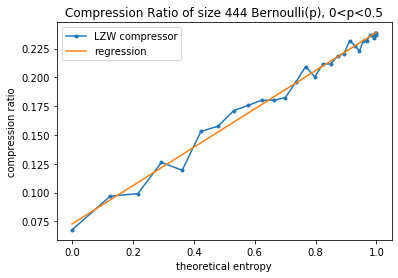

compression ratio:  0.22297297297297297
estimated entropy:  0.8998750950647422
P(e) lower bound :  0.3158189001968203
--------------------------

Kevin Durant
p =  0.4846153846153846
length =  390
y = ax + b model
a =  [0.17006322]
b =  0.0783178413183529


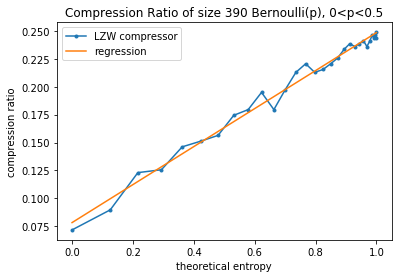

compression ratio:  0.23076923076923078
estimated entropy:  0.8940482727113789
P(e) lower bound :  0.31067480847412526
--------------------------

LeBron James
p =  0.4746136865342163
length =  453
y = ax + b model
a =  [0.16498802]
b =  0.07227352034461668


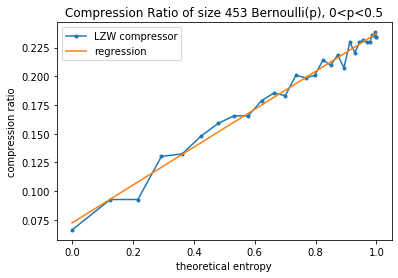

compression ratio:  0.22958057395143489
estimated entropy:  0.9501722333650199
P(e) lower bound :  0.3692224470027123
--------------------------

Russell Westbrook
p =  0.49195402298850577
length =  435
y = ax + b model
a =  [0.16835381]
b =  0.0727529469302271


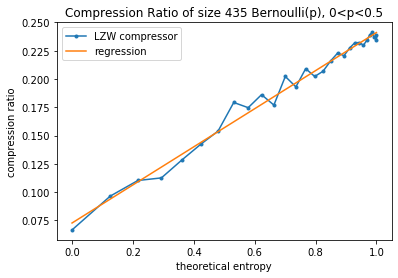

compression ratio:  0.22528735632183908
estimated entropy:  0.9033503325965725
P(e) lower bound :  0.318964237147245
--------------------------

James Harden
p =  0.47854077253218885
length =  466
y = ax + b model
a =  [0.15748253]
b =  0.07797940512246111


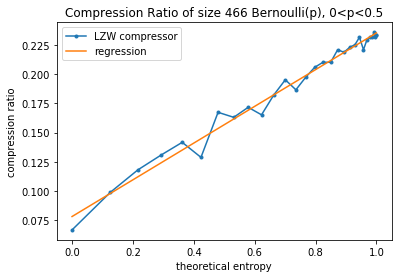

compression ratio:  0.22103004291845493
estimated entropy:  0.9049168876584915
P(e) lower bound :  0.3204030338273627
--------------------------

Paul George
p =  0.47619047619047616
length =  399
y = ax + b model
a =  [0.17349186]
b =  0.07128439056794617


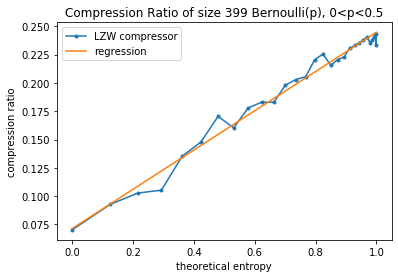

compression ratio:  0.23558897243107768
estimated entropy:  0.943354759019711
P(e) lower bound :  0.36069120437844077
--------------------------

Kyrie Irving
p =  0.46786632390745503
length =  389
y = ax + b model
a =  [0.16723024]
b =  0.07922432642585099


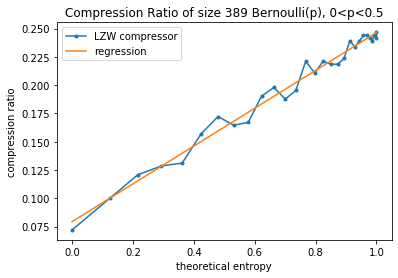

compression ratio:  0.2390745501285347
estimated entropy:  0.9519774715040815
P(e) lower bound :  0.37158097847087684
--------------------------

Chris Paul
p =  0.47044334975369456
length =  406
y = ax + b model
a =  [0.16660645]
b =  0.07767785136044937


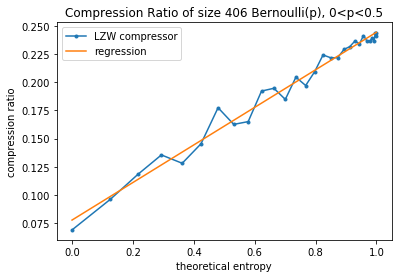

compression ratio:  0.2315270935960591
estimated entropy:  0.9193614533799764
P(e) lower bound :  0.33430366079612733
--------------------------



In [92]:
metric = "PTS_G"
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"
quality = 9 # best but slow
span = 3
#############
for player_name in player_list_1:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = get_delta(player_data)
    player_delta_string = list_to_string(player_delta)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    size = len(player_delta)
    print("p = ", p)
    print("length = ", size)
    
    compressed = compress(player_delta_string)
    compression_ratio = len(compressed)/len(player_delta_string)    
    ent = get_entropy(size, compression_ratio)
    
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    print("P(e) lower bound : ", inverse_binary_entropy(ent[0], a=0.0001))
    print("--------------------------")
    print()

# Binary Prediction Error

In [45]:
def mse(actual, pred):
    return ((actual - pred) ** 2).mean()

def rmse(actual, pred):
    return np.sqrt(((actual - pred) ** 2).mean())

def mape(actual, pred):
    actual = pd.DataFrame(actual)
    pred = pd.DataFrame(pred)
    mask = (actual != 0)
    return (np.abs(actual - pred) / actual[mask]).mean()

def window_stack(a, stepsize=1, width=3):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

# get the EWMA from raw scores
def run_ewma(vals, window):
    # take EWMA in both directions with a smaller span term
    fwd = pd.DataFrame(vals).ewm(span=window).mean().values.flatten() # take EWMA in fwd direction
    bwd = pd.DataFrame(vals[::-1]).ewm(span=window).mean().values.flatten() # take EWMA in bwd direction

#     runs_smoothed = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
#     runs_smoothed = np.mean( runs_smoothed, axis=0 ) # average
    runs_smoothed = 0.95 * fwd + 0.05 * bwd[::-1]
    return runs_smoothed

def ts_estimate(player_data, player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep):
    #     player_data # array-like

    T = player_data.shape[0]
    N = nbr_innings_to_test # nbr of rows
    M = int(T/N) # total nbr of columns
    M1 = M - 1 # nbr of columns for training
    key1 = str(player_name) 

    trainDF = pd.DataFrame(index=range(0, M1*N), data={key1: player_data[0:M1*N]})
    testDF = pd.DataFrame(index=range(0, T - (M1*N)), data={key1: player_data[M1*N: ]})

    mod = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
    mod.fit(trainDF)
    imputedDf = mod.denoisedDF()
    
    player_data = np.reshape(player_data, [1, player_data.shape[0]]).T
    pred_matrix = window_stack(player_data, 1, N-1)
    pred = np.dot(pred_matrix, mod.weights)
    pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))

    return pred, N*M1

/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


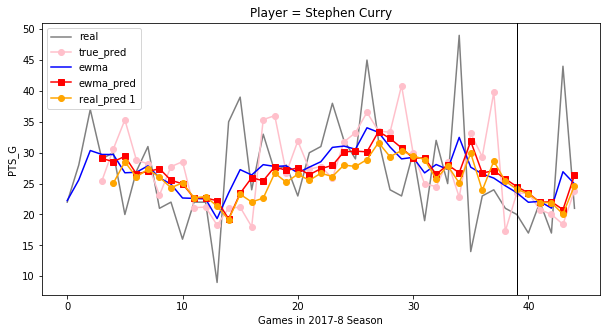

2018-02-26 07:30:00
45
40


In [94]:
metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5
xlabel = 'Games in 2017-8 Season'
start_date = "2017-10-01"
end_date = "2018-10-01"

# # player_list = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
# # player_list = ['Al Horford','Trevor Ariza','Eric Gordon']
# player_list = ['Stephen Curry', 'LeBron James','Al Horford','Trevor Ariza']

##############################################
player_name = player_list_1[0]
# for player_name in player_list_1:

plt.figure(figsize=(10,5))

player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]
game_date = player_stat.iloc[45]['date']

# true data
player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
plt.plot(player_data, label="real", color="grey")

# true pred
ts_pred, interv = ts_estimate(player_data.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
plt.plot(ts_pred, label="true_pred", color="pink", marker='o')

# ewma data
player_data_ewma = run_ewma(player_data, moving_avg_window)
player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})
plt.plot(player_data_ewma, label="ewma", color="blue")

# ewma pred
ts_pred, interv = ts_estimate(player_data_ewma.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
ts_pred = pd.DataFrame(index=range(0, len(ts_pred)), data={player_name: ts_pred})
plt.plot(ts_pred, label="ewma_pred", color="red", marker='s')

# recover X(t) - by ewma equation
alpha = 2/(moving_avg_window+1)
real_pred = [np.nan]*nbr_innings_to_test
for loc in range(nbr_innings_to_test,ts_pred.shape[0],1):
    x_t = (ts_pred.iloc[loc] - player_data_ewma.iloc[loc-1] * (1-alpha)) /alpha
    real_pred.append(x_t.values[0])
plt.plot(real_pred, label="real_pred 1", color="orange", marker='o')

plt.legend()
plt.xlabel(xlabel)
plt.ylabel(metric)
plt.axvline(x=interv-1, linewidth=1, color='black', label='Training End')
plt.title('Player = '+player_name)
plt.show()

print(game_date)
print(player_data.shape[0])
print(interv)

In [84]:
true_delta = get_delta(player_data[nbr_innings_to_test:].squeeze())
pred_delta = get_delta(pd.Series(real_pred[nbr_innings_to_test:]))

error = np.mean(np.array(true_delta) != np.array(pred_delta))

In [93]:
error

0.6

In [ ]:
player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]


true_delta = get_delta(player_data[nbr_innings_to_test:].squeeze())
pred_delta = get_delta(pd.Series(real_pred[nbr_innings_to_test:]))

error = np.mean(np.array(true_delta) != np.array(pred_delta))